In [1]:
import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from physlite_events import physlite_events, get_branch_forms, get_lazy_form

In [2]:
%%time
#f = uproot.open("user.nihartma.22884623.EXT0._000001.DAOD_PHYSLITE.test.pool.root")
filename = "/home/nikolai/data/user.elmsheus.21230205.EXT0._000002.DAOD_PHYSLITE.mc.pool.root"
tree = uproot.open(f"{filename}:CollectionTree")

CPU times: user 1.52 s, sys: 25.1 ms, total: 1.55 s
Wall time: 1.55 s


In [3]:
%%time
events = physlite_events(tree, verbose=True)

Can't interpret PrimaryVerticesAuxDyn.neutralParticleLinks
CPU times: user 481 ms, sys: 9.95 ms, total: 491 ms
Wall time: 492 ms


In [4]:
%%time
form = get_lazy_form(get_branch_forms(tree))

Can't interpret PrimaryVerticesAuxDyn.neutralParticleLinks
CPU times: user 105 ms, sys: 3.11 ms, total: 108 ms
Wall time: 106 ms


In [5]:
def has_overlap(obj1, obj2, filter_dr):
    """
    Return mask array where obj1 has overlap with obj2 based on a filter
    function on deltaR (and pt of the first one)
    """
    dr = obj1.delta_r(obj1.nearest(obj2))
    return ak.fill_none(filter_dr(dr, obj1.pt), False)


def match_dr(dr, pt, cone_size=0.2):
    return dr < cone_size


def match_boosted_dr(dr, pt, max_cone_size=0.4):
    return dr < np.minimum(*ak.broadcast_arrays(10000. / pt + 0.04, max_cone_size))

In [6]:
def muon_track_links(muons):
    return muons["inDetTrackParticleLink.m_persIndex"].mask[
        muons["inDetTrackParticleLink.m_persKey"] != 0
    ]

In [7]:
def jet_ghost_links(jets):
    return jets.GhostTrack.m_persIndex.mask[jets.GhostTrack.m_persKey != 0]

In [8]:
def is_associated(idx1, idx2):
    """
    Used for muon-jet ghost association
    """
    # TODO: check if keys also match
    xx1, xx2 = ak.unzip(ak.cartesian([idx1, idx2], nested=True))
    return ak.fill_none(ak.any(ak.any(xx1 == xx2, axis=-1), axis=-1), False)

In [9]:
def has_overlap_mujet(obj1, obj2, filter_dr):
    """
    Check if either ghost associated or delta_r match
    """
    if "GhostTrack" in obj1.fields:
        ghost_match = is_associated(jet_ghost_links(obj1), muon_track_links(obj2))
    else:
        ghost_match = is_associated(muon_track_links(obj1), jet_ghost_links(obj2))
    return (
        has_overlap(obj1, obj2, filter_dr)
        | ghost_match
    )

In [80]:
def get_obj_sel(evt):
    # TODO: sort jets

    # skip events without primary vertex (important for data)
    evt = evt[ak.num(evt.PrimaryVertices.x) > 0]

    # lepton selection
    evt["Electrons", "baseline"] = (
        (evt.Electrons.DFCommonElectronsLHLooseBL == 1)
        & (evt.Electrons.pt > 7000)
        & (np.abs(evt.Electrons.eta) < 2.47)
    )
    evt["Electrons", "signal"] = (
        evt.Electrons.baseline
        & (evt.Electrons.DFCommonElectronsLHTight == 1)
        & (evt.Electrons.topoetcone20 / evt.Electrons.pt < 0.2)
        & (evt.Electrons.ptvarcone20_TightTTVA_pt1000 / evt.Electrons.pt < 0.15)
    )
    evt["Muons", "baseline"] = (
        (evt.Muons.DFCommonGoodMuon == 1)
        & (evt.Muons.pt > 6000)
        & (np.abs(evt.Muons.eta) < 2.7)
    )
    evt["Muons", "signal"] = (
        evt.Muons.baseline
        & (np.abs(evt.Muons.eta) < 2.5)
        & (evt.Muons.topoetcone20 / evt.Muons.pt < 0.3)
        & (evt.Muons.ptvarcone30 / evt.Muons.pt < 0.15)
    )

    # jet selection
    evt["Jets", "baseline"] = evt.Jets.pt >= 20000
    jvt_pt_min = 20000
    jvt_pt_max = 60000
    jvt_eta_max = 2.4
    evt["Jets", "passJvt"] = (
        ((evt.Jets.pt >= jvt_pt_min) & (evt.Jets.pt < jvt_pt_max) & (evt.Jets.Jvt > 0.2) & (np.abs(evt.Jets.eta) < jvt_eta_max))
        | ((evt.Jets.pt >= jvt_pt_max) | (evt.Jets.pt < jvt_pt_min) | (np.abs(evt.Jets.eta) >= jvt_eta_max))
    )
    evt["Jets", "signal"] = evt.Jets.baseline & evt.Jets.passJvt & (np.abs(evt.Jets.eta) < 4.5)

    ## "simplified" overlap removal
    # remove Jets overlapping with Electrons
    evt["Jets", "passOR"] = (
        evt.Jets.baseline
        & (
            ~has_overlap(
                evt.Jets,
                evt.Electrons[evt.Electrons.baseline],
                match_dr
            )
        )
    )
    # remove Electrons overlapping (boosted cone) with remaining Jets (if they pass jvt)
    evt["Electrons", "passOR"] = (
        evt.Electrons.baseline
        & (
            ~has_overlap(
                evt.Electrons,
                evt.Jets[evt.Jets.passOR & evt.Jets.passJvt],
                match_boosted_dr
            )
        )
    )
    # remove Jets overlapping with Muons (TODO: check ntrack requirement, ghost association)
    evt["Jets", "passOR"] = (
        evt.Jets.passOR
        & ~(
            has_overlap_mujet(evt.Jets, evt.Muons[evt.Muons.baseline], match_dr)
            & (evt.Jets.NumTrkPt500[:, :, 0] < 3)
        )
    )
    # remove Muons overlapping (boosted cone) with remaining Jets (if they pass jvt)
    evt["Muons", "passOR"] = (
        evt.Muons.baseline
        & (
            ~has_overlap_mujet(
                evt.Muons,
                evt.Jets[evt.Jets.baseline & evt.Jets.passOR & evt.Jets.passJvt],
                match_boosted_dr
            )
        )
    )
    return evt


In [81]:
%%time
evt_ak = get_obj_sel(events)

CPU times: user 1.02 s, sys: 48 µs, total: 1.02 s
Wall time: 1.02 s


In [12]:
from physlite_events import Factory, get_lazy_form, LazyGet

In [13]:
import json

In [14]:
form = json.dumps(get_lazy_form(get_branch_forms(tree)))

Can't interpret PrimaryVerticesAuxDyn.neutralParticleLinks


In [15]:
container = LazyGet(tree, verbose=True)

In [16]:
factory = Factory(form, tree.num_entries, container)

In [34]:
%%time
get_obj_sel(factory.events)

CPU times: user 1.28 s, sys: 351 µs, total: 1.28 s
Wall time: 1.3 s


<Array [...] type='50000 * {"AntiKt10TruthTrimmedPtFrac5SmallR20Jets": var * {"D...'>

In [45]:
%%time
get_obj_sel(
    Factory(form, tree.num_entries, LazyGet(tree, verbose=False, cache=factory.container.cache)).events
)

CPU times: user 1.33 s, sys: 10 ms, total: 1.34 s
Wall time: 1.34 s


<Array [...] type='50000 * {"AntiKt10TruthTrimmedPtFrac5SmallR20Jets": var * {"T...'>

In [19]:
import timeit

In [20]:
def benchmark():
    tree = uproot.open(f"{filename}:CollectionTree")
    events = physlite_events(tree)
    get_obj_sel(events)

In [52]:
times = timeit.Timer(benchmark).repeat(number=1, repeat=5)

Can't interpret PrimaryVerticesAuxDyn.neutralParticleLinks
Can't interpret PrimaryVerticesAuxDyn.neutralParticleLinks
Can't interpret PrimaryVerticesAuxDyn.neutralParticleLinks
Can't interpret PrimaryVerticesAuxDyn.neutralParticleLinks
Can't interpret PrimaryVerticesAuxDyn.neutralParticleLinks


In [53]:
times, min(times)

([4.820429678999062,
  4.7871432130014,
  4.734087848999479,
  4.760186741001235,
  4.772494769000332],
 4.734087848999479)

In [84]:
import time

In [86]:
def run_benchmark_no_overhead():
    times = []
    for i in range(5):
        tree = uproot.open(f"{filename}:CollectionTree")
        events = physlite_events(tree)
        start = time.time()
        get_obj_sel(events)
        duration = time.time() - start
        times.append(duration)
    return times, min(times)

In [87]:
run_benchmark_no_overhead()

Can't interpret PrimaryVerticesAuxDyn.neutralParticleLinks
Can't interpret PrimaryVerticesAuxDyn.neutralParticleLinks
Can't interpret PrimaryVerticesAuxDyn.neutralParticleLinks
Can't interpret PrimaryVerticesAuxDyn.neutralParticleLinks
Can't interpret PrimaryVerticesAuxDyn.neutralParticleLinks


([2.4001080989837646,
  2.4151716232299805,
  2.4031999111175537,
  2.4241979122161865,
  2.38071346282959],
 2.38071346282959)

In [50]:
def run_benchmark_obj_sel():
    tree = uproot.open(f"{filename}:CollectionTree")
    events = physlite_events(tree)
    get_obj_sel(events)
    times = timeit.Timer(lambda: get_obj_sel(events)).repeat(number=1, repeat=5)
    return times, min(times)

In [59]:
run_benchmark_obj_sel()

Can't interpret PrimaryVerticesAuxDyn.neutralParticleLinks


([1.0454151580015605,
  1.0084446229993773,
  1.0026163869988522,
  1.0228222029982135,
  1.0791139979992295],
 1.0026163869988522)

In [25]:
50000 / 5

10000.0

In [72]:
loaded_keys = list(factory.container.cache.keys())

In [73]:
from deserialization_hacks import tree_arrays

In [74]:
def run_benchmark_preload():
    tree = uproot.open(f"{filename}:CollectionTree")
    cache = tree_arrays(tree, lambda branch: branch.name in loaded_keys)
    container = LazyGet(tree, verbose=False, cache=cache)
    form = json.dumps(get_lazy_form(get_branch_forms(tree)))
    return timeit.Timer(
        lambda: get_obj_sel(Factory(form, tree.num_entries, container).events)
    ).repeat(number=1, repeat=5)

In [75]:
run_benchmark_preload()

Can't interpret PrimaryVerticesAuxDyn.neutralParticleLinks


[1.0754890900025202,
 1.0704303519996756,
 1.0420263699998031,
 1.0395254109971575,
 1.040600099000585]

In [25]:
# produced with athena + ST
# using https://gitlab.cern.ch/nihartma/enaf
def get_st_ntuple():
    f = uproot.open("/home/nikolai/code/enaf/run/ST_ntuple.root")
    tree = f["analysis"]
    keys = [k for k in tree.keys()]
    evt = ak.zip(
        {
            part[0].upper() + part[1:] + "s" : ak.zip(
                {k.split("_")[1] : tree[k].array() for k in keys if part in k}
            )
            for part in ["jet", "electron", "muon"]
        },
        depth_limit=1
    )
    # convert to bools
    bools = ["passOR", "passJvt", "baseline", "signal", "bad"]
    for part in evt.fields:
        for var in evt[part].fields:
            if var in bools:
                evt[part, var] = evt[part, var] == 1
    return evt

In [26]:
evt_st = get_st_ntuple()

In [27]:
evt_st.Electrons.baseline

<Array [[True], [], [], ... True], [], [True]] type='50000 * var * bool'>

In [28]:
df = []
for obj in ["Electrons", "Muons", "Jets"]:
    flags = ["all", "baseline", "passOR", "signal"]
    #if obj == "Jets":
    #    flags += ["passJvt"]
    for flag in flags:
        counts = []
        for e in [evt_ak, evt_st]:
            if flag != "all":
                counts.append(ak.count_nonzero(e[obj, flag]))
            else:
                counts.append(ak.sum(ak.num(e[obj])))
        entry = {
            "object" : obj,
            "flag" : flag,
            "athena/SUSYTools" : counts[1],
            "columnar analysis" : counts[0]
        }
        df.append(entry)
df = pd.DataFrame(df)

In [29]:
df.set_index(["object", "flag"])

athena/SUSYTools  columnar analysis
object    flag                                         
Electrons all                  23081              23081
          baseline             19219              19211
          passOR               18907              18896
          signal               14457              14623
Muons     all                  26475              26475
          baseline             22826              23310
          passOR               19455              17515
          signal               17453              18226
Jets      all                 524205             524205
          baseline            318948             318948
          passOR              296403             298242
          signal              298842             299005

In [30]:
df.set_index(["object", "flag"]).loc["Muons", "passOR"]

athena/SUSYTools     19455
columnar analysis    17515
Name: (Muons, passOR), dtype: int64

In [31]:
df.set_index(["object", "flag"]).loc["Jets", "passOR"]

athena/SUSYTools     296403
columnar analysis    298242
Name: (Jets, passOR), dtype: int64

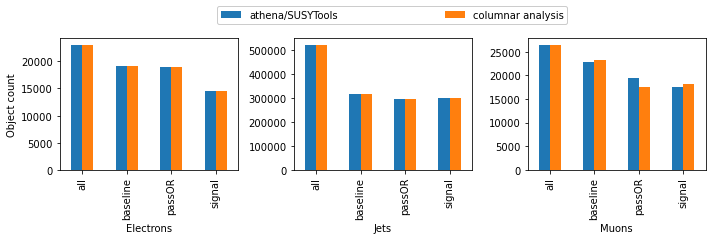

In [32]:
gb = df.groupby("object")
fig, axs = plt.subplots(figsize=(10, 3), ncols=len(gb), nrows=1)
for ax, group in zip(axs.ravel(), gb):
    group[1].pop("object")
    group[1].set_index("flag").plot(kind="bar", ax=ax, legend=False)
    ax.set_xlabel(group[0])
    if ax is axs[0]:
        ax.set_ylabel("Object count")
legend = fig.legend(
    *ax.get_legend_handles_labels(),
    framealpha=1,
    ncol=2,
    bbox_to_anchor=(0.3, 1.02, 0.5, .102),
    mode="expand",
)
fig.tight_layout()
fig.savefig("object_count_columnar_vs_st.pdf", bbox_extra_artists=(legend,), bbox_inches='tight')

Loading part0-AnalysisMuonsAuxDyn.combinedTrackParticleLink.m_persKey%content-data
Loading part0-AnalysisMuonsAuxDyn.combinedTrackParticleLink.m_persIndex%content-data
Loading part0-CombinedMuonTrackParticlesAuxDyn.truthOrigin%offsets-offsets
Loading part0-PrimaryVerticesAuxDyn.z%content-data
Loading part0-CombinedMuonTrackParticlesAuxDyn.z0%content-data


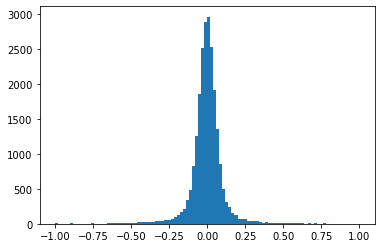

In [33]:
plt.hist(
    ak.flatten(ak.singletons(
        evt_ak.Muons[evt_ak.Muons.baseline].trackParticle.z0 - ak.firsts(evt_ak.PrimaryVertices.z)
    ), axis=None),
    bins=100, range=(-1, 1)
);

In [34]:
def overlay(selection, ax=None, **kwargs):
    ax = ax or plt.gca()
    ax.hist(ak.to_numpy(ak.flatten(selection(evt_ak))), **kwargs)
    ax.hist(ak.to_numpy(ak.flatten(selection(evt_st))), **kwargs)
    return ax

In [35]:
events.PrimaryVertices[:, 0].z

<Array [-46.9, 26.2, -35.8, ... -83.8, -4.79] type='50000 * float32'>

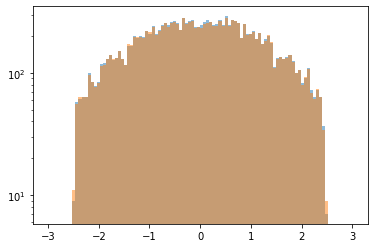

In [36]:
ax = overlay(lambda evt: evt.Electrons[evt.Electrons.signal].eta, bins=100, range=(-3, 3), alpha=0.5)
ax.set_yscale("log")

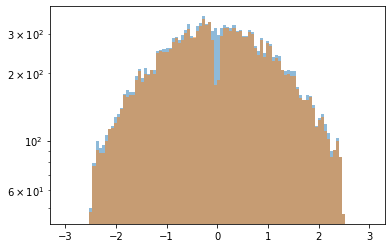

In [37]:
ax = overlay(lambda evt: evt.Muons[evt.Muons.signal].eta, bins=100, range=(-3, 3), alpha=0.5)
ax.set_yscale("log")

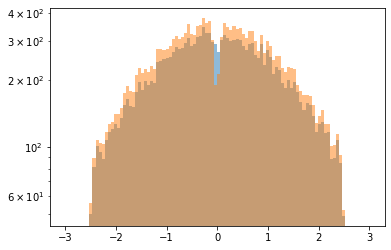

In [38]:
ax = overlay(lambda evt: evt.Muons[evt.Muons.passOR].eta, bins=100, range=(-3, 3), alpha=0.5)
ax.set_yscale("log")

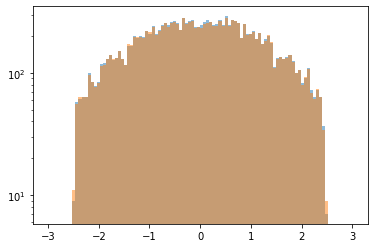

In [39]:
ax = overlay(lambda evt: evt.Electrons[evt.Electrons.signal].eta, bins=100, range=(-3, 3), alpha=0.5)
ax.set_yscale("log")